## Goal

I find an improved implementation of anchor-word algorithm at https://aclanthology.org/D19-1504.pdf . I want to see how well it performs on a simulated dataset that satsifies the "anchor-word" assumption (the first $k$ rows of $F$ is a diagonal matrix)

Note this example is very simple and unrealistic. It's only meant for sanity check. 

In [1]:
import os
import sys
import pandas as pd
from scipy import sparse
from sklearn.decomposition import NMF, LatentDirichletAllocation

import numpy as np
import matplotlib.pyplot as plt

script_dir = "../"
sys.path.append(os.path.abspath(script_dir))
from file2 import *
from factorize import *
from smallsim_functions_anchor import *
from misc import *


np.random.seed(123)

## small, uncorrelated example

In [2]:
n = 1000
p = 500
k = 4
doc_len = 100

sim = smallsim_independent(n = n, p = p, k = k, doc_len = doc_len)
X = sparse.coo_matrix(sim["X"])
L = sim["L"]
F = sim["F"]

Bows = X2Bows(X)
C, D1, D2 = bows2C(Bows, min_tokens=0)

C.shape

[file.bows2C] Start constructing dense C...
- Counting the co-occurrence for each document...
+ Finish constructing C and D!
  - The sum of all entries = 1.000000
  - Elapsed Time = 0.3171 seconds


(500, 500)

In [3]:
S, B, A, Btilde, Cbar, C_rowSums, diagR, C = factorizeC(C, K=k, rectifier='AP', optimizer='activeSet')

+ Start rectifying C...
+ Start alternating projection
  - 1-th iteration... (3.143473e-04 / 4.940712e-08)
  - 2-th iteration... (1.339495e-08 / 4.940714e-08)
  - 3-th iteration... (1.130270e-10 / 4.940714e-08)
  - 4-th iteration... (9.537263e-13 / 4.940714e-08)
  - 5-th iteration... (8.047353e-15 / 4.940714e-08)
  - 6-th iteration... (6.810532e-17 / 4.940714e-08)
  - 7-th iteration... (1.669514e-18 / 4.940714e-08)
  - 8-th iteration... (1.068630e-18 / 4.940714e-08)
  - 9-th iteration... (1.053088e-18 / 4.940714e-08)
  - 10-th iteration... (1.031591e-18 / 4.940714e-08)
  - 11-th iteration... (1.646279e-18 / 4.940714e-08)
  - 12-th iteration... (1.728064e-18 / 4.940714e-08)
  - 13-th iteration... (1.221014e-18 / 4.940714e-08)
  - 14-th iteration... (9.601573e-19 / 4.940714e-08)
  - 15-th iteration... (1.318818e-18 / 4.940714e-08)
+ Finish alternating projection
  - Elapsed seconds = 0.0912

  - Finish rectifying C! [0.091223]
+ Start finding the set of anchor bases S...
[inference.findS

## Evaulate results

In [4]:
topic_idx = match_topics(F, B).astype(int)
topic_idx

array([1, 2, 0, 3])

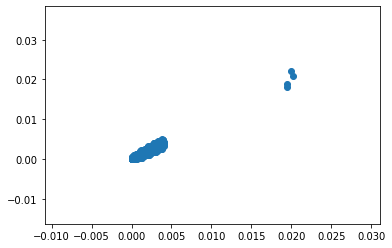

In [5]:
plt.scatter(F.flatten(), B[:,topic_idx].flatten())

In [6]:
S[topic_idx]

array([0, 1, 2, 3])

In [7]:
F[:k, :]

array([[0.02000822, 0.        , 0.        , 0.        ],
       [0.        , 0.0195032 , 0.        , 0.        ],
       [0.        , 0.        , 0.0201789 , 0.        ],
       [0.        , 0.        , 0.        , 0.01943308]])

In [8]:
B[:k, topic_idx]

array([[0.02210265, 0.        , 0.        , 0.        ],
       [0.        , 0.01807571, 0.        , 0.        ],
       [0.        , 0.        , 0.02086205, 0.        ],
       [0.        , 0.        , 0.        , 0.01874497]])

In [9]:
# B[np.ix_(S[topic_idx],topic_idx)].round(4)

array([[0.0221, 0.    , 0.    , 0.    ],
       [0.    , 0.0181, 0.    , 0.    ],
       [0.    , 0.    , 0.0209, 0.    ],
       [0.    , 0.    , 0.    , 0.0187]])

In [10]:
# compare A and LLt/n
A_reorder = A[topic_idx,:]
A_reorder = A_reorder[:, topic_idx]
A_reorder.round(decimals=2)

array([[0.14, 0.02, 0.02, 0.02],
       [0.02, 0.2 , 0.02, 0.02],
       [0.02, 0.02, 0.21, 0.03],
       [0.02, 0.02, 0.03, 0.19]])

In [11]:
L = sim["L"]
(L.T.dot(L)/n).round(decimals=2)

array([[0.16, 0.02, 0.02, 0.02],
       [0.02, 0.19, 0.02, 0.03],
       [0.02, 0.02, 0.2 , 0.03],
       [0.02, 0.03, 0.03, 0.17]])

LDA can find those anchor words very well too

In [12]:
# lda = LatentDirichletAllocation(n_components=k, max_iter=20,
#                                 random_state=0)
# lda.fit(X)

# B2 = (lda.components_ / lda.components_.sum(axis=1)[:, np.newaxis]).T
# idx = match_topics(B2, F).astype(int)
# B2[anchor_words[idx],:].round(3)